In [39]:
#Load libraries and packages
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

# Loading in the Dataset

- We use pandas as our main package for data manipulation and analysis
- Dataset has been pre-cleaned in excel:
    - Removed any rows with empty cells
    - Changed relevant columns from numerical data to categorical using conversion table provided
        - e.g. For Alcohol use: <br/> 
            0 - Yes, <br/> 
            1 - No/No Information

In [40]:
df = pd.read_csv("HPGH_labeled.csv")

In [3]:
df.head()

,Unnamed: 0,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Alcohol,Drug,Product,Narrative
0,0,190103353,2019-01-01,26,Male,Black/African American,Hand,Fracture,Treated and Admitted/Hospitalized,Home,No Fire Involved or Fire Involvement Not Recorded,Yes,No/No information,FIREWORKS,26YOM WAS INTOXICATED ATTEMPTING TO LIGHT A LA...
1,1,190103412,2019-01-01,73,Female,White,Head,Hematoma,Treated and Admitted/Hospitalized,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,GLASS DOORS OR DOORS WITH GLASS PANELS,73YOF FELL STRUCK HEAD ON A GLASS DOOR AND SUS...
2,2,190103415,2019-01-01,85,Female,White,Lower Trunk,Fracture,Treated and Admitted/Hospitalized,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,FLOORS OR FLOORING MATERIALS,85YOF WAS TAKING FOOD OUT OF THE MICROWAVE OVE...
3,3,190103459,2019-01-01,4,Male,White,Shoulder,Fracture,Treated/Examined and Released,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,"BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",4 YO M FELL OFF BED AND LANDED ON RT SHOULDER ...
4,4,190104001,2019-01-01,23,Male,White,Wrist,Laceration,Treated/Examined and Released,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,"KNIVES, NOT ELSEWHERE CLASSIFIED","23YOM TRIPPED AND FELL INTO OPEN DISHWASAHER, ..."


# Preparation

The dataset is sliced into the independent variables and the dependent variable we are interested in predicting using our model.

The independent variables used are (we are assuming these variables are independent):
- Age, body part, diagnosis, location, alcohol involvement, and drug involvement

The dependent variable used is:
- Disposition 

The independent variables are broken down into dummy variables and normalised.

Finally the subset is split into a test and train set to discourage the model overfitting the data.

In [4]:
df['Disposition'].value_counts()

Treated/Examined and Released        237324
Treated and Admitted/Hospitalized     30376
Treated and Transferred                3732
Held for Observation                   3527
Left Without Being Seen                2446
Fatality, Incl. DOA, Died in ER         234
Name: Disposition, dtype: int64

In [41]:
df.drop(df[df.Disposition == 'Fatality, Incl. DOA, Died in ER'].index, inplace=True)

In [42]:
#Create dummy variables for independent variables
Feature = df[['Age','Body_Part','Diagnosis','Location','Alcohol','Drug']]
Feature = pd.concat([Feature,pd.get_dummies(Feature,columns=['Body_Part','Diagnosis','Location','Alcohol','Drug'])], axis=1)
Feature = Feature.drop(columns=['Body_Part','Diagnosis','Location','Alcohol','Drug'])
Feature.head()

,Age,Age,Body_Part_25-50% of Body,Body_Part_All Parts Body,Body_Part_Ankle,Body_Part_Ear,Body_Part_Elbow,Body_Part_Eyeball,Body_Part_Face,Body_Part_Finger,...,Location_Industrial,Location_Mobile/Manufactured Home,Location_Other Public Property,Location_Place of Recreation or Sports,Location_School/Daycare,Location_Street or Highway,Alcohol_No/No Information,Alcohol_Yes,Drug_No/No information,Drug_Yes
0,26,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,73,73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,85,85,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,23,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [43]:
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)

In [44]:
y = df['Disposition'].values

In [45]:
#Split dataset into 80% test and 20% train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (221924, 70) (221924,)
Test set: (55481, 70) (55481,)


# ML Algorithms

## K Nearest Neighbor Classification

In [10]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.8145311 , 0.77098466, 0.84419891, 0.84800202, 0.86209693,
       0.86070907, 0.86822516, 0.86734197, 0.86990141, 0.87044213,
       0.87222653, 0.87283935, 0.87345217, 0.87383068, 0.87417314,
       0.87401092, 0.87465979, 0.87530866, 0.87539879, 0.87547088,
       0.87554298, 0.87539879, 0.87574124, 0.87500225, 0.87512842,
       0.87525459, 0.87523657, 0.87572322, 0.87561508])

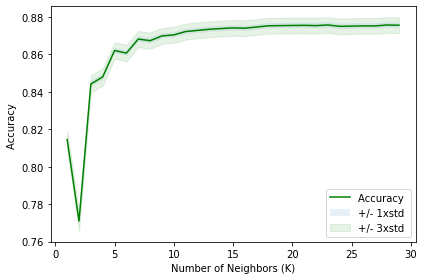

In [11]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [12]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8757412447504551 with k= 23


## Decision Tree Classification

In [13]:
#Decision Tree Classification
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

['Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released']
['Treated/Examined and Released' 'Treated and Admitted/Hospitalized'
 'Treated/Examined and Released' 'Left Without Being Seen'
 'Treated/Examined and Released']


In [14]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.8716858023467493


In [46]:
classifier = LogisticRegression(solver='lbfgs', max_iter=10000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8717038265352103


# Critical Analysis

In [15]:
#Grouping cases by disposition
df.groupby(['Disposition']).count()

,Unnamed: 0,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Body_Part,Diagnosis,Location,Fire_Involvement,Alcohol,Drug,Product,Narrative
Disposition,,,,,,,,,,,,,,
Held for Observation,3527,3527,3527,3527,3527,3527,3527,3527,3527,3527,3527,3527,3527,3527
Left Without Being Seen,2446,2446,2446,2446,2446,2446,2446,2446,2446,2446,2446,2446,2446,2446
Treated and Admitted/Hospitalized,30376,30376,30376,30376,30376,30376,30376,30376,30376,30376,30376,30376,30376,30376
Treated and Transferred,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732
Treated/Examined and Released,237324,237324,237324,237324,237324,237324,237324,237324,237324,237324,237324,237324,237324,237324


In [36]:
#Percentage of cases where patient was treated/examined and released
(237324)/(237324+3527+2446+30376+3732)

0.8555145004596169

In [17]:
print (predTree [0:20])

['Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released'
 'Treated/Examined and Released' 'Treated/Examined and Released']


In [19]:
predTreat = list1.count(list1[0])
print(predTreat)

53949


In [20]:
len(list1)

55481

In [38]:
#Percentage of treated/examined and released cases predicted
53949/55481

0.9723869432778789

Decision tree predicted over 97% of test data were minor injuries

# Second Attempt

In this attempt we group severity into two groups:
- Medical emergencies that require immediate attention and professional care
    - Treated and Admitted/Hospitalized
    - Treated and Transferred
- Non emergency injuries that could still require treatment
    - Treated/Examined and Released
    - Held for Observation
    - Left Without Being Seen

In [47]:
#Group severity into two groups: medical treatment needed vs not needed
df.replace({'Treated and Admitted/Hospitalized': 'Severe', 
            'Treated and Transferred': 'Severe',
            'Treated/Examined and Released' : 'Not severe',
            'Held for Observation' : 'Not severe',
            'Left Without Being Seen' : 'Not severe'}, inplace=True)

In [23]:
df.head()

,Unnamed: 0,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Alcohol,Drug,Product,Narrative
0,0,190103353,2019-01-01,26,Male,Black/African American,Hand,Fracture,Severe,Home,No Fire Involved or Fire Involvement Not Recorded,Yes,No/No information,FIREWORKS,26YOM WAS INTOXICATED ATTEMPTING TO LIGHT A LA...
1,1,190103412,2019-01-01,73,Female,White,Head,Hematoma,Severe,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,GLASS DOORS OR DOORS WITH GLASS PANELS,73YOF FELL STRUCK HEAD ON A GLASS DOOR AND SUS...
2,2,190103415,2019-01-01,85,Female,White,Lower Trunk,Fracture,Severe,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,FLOORS OR FLOORING MATERIALS,85YOF WAS TAKING FOOD OUT OF THE MICROWAVE OVE...
3,3,190103459,2019-01-01,4,Male,White,Shoulder,Fracture,Not severe,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,"BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",4 YO M FELL OFF BED AND LANDED ON RT SHOULDER ...
4,4,190104001,2019-01-01,23,Male,White,Wrist,Laceration,Not severe,Home,No Fire Involved or Fire Involvement Not Recorded,No/No Information,No/No information,"KNIVES, NOT ELSEWHERE CLASSIFIED","23YOM TRIPPED AND FELL INTO OPEN DISHWASAHER, ..."


In [48]:
#Create dummy variables for independent variables
Feature = df[['Age','Body_Part','Diagnosis','Location','Alcohol','Drug']]
Feature = pd.concat([Feature,pd.get_dummies(Feature,columns=['Body_Part','Diagnosis','Location','Alcohol','Drug'])], axis=1)
Feature = Feature.drop(columns=['Body_Part','Diagnosis','Location','Alcohol','Drug'])
Feature.head()

,Age,Age,Body_Part_25-50% of Body,Body_Part_All Parts Body,Body_Part_Ankle,Body_Part_Ear,Body_Part_Elbow,Body_Part_Eyeball,Body_Part_Face,Body_Part_Finger,...,Location_Industrial,Location_Mobile/Manufactured Home,Location_Other Public Property,Location_Place of Recreation or Sports,Location_School/Daycare,Location_Street or Highway,Alcohol_No/No Information,Alcohol_Yes,Drug_No/No information,Drug_Yes
0,26,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,73,73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,85,85,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,23,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [49]:
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)

In [50]:
y = df['Disposition'].values

In [51]:
#Split dataset into 80% test and 20% train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (221924, 70) (221924,)
Test set: (55481, 70) (55481,)


# ML Algorithhms

## K Nearest Neighbor Classification

In [28]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.85308484, 0.8828608 , 0.87785007, 0.89181882, 0.88898902,
       0.89381951, 0.89239559, 0.89529749, 0.89394568, 0.89574809,
       0.89524342, 0.89648709, 0.89616265, 0.89801914, 0.89709991,
       0.89764063, 0.89720805, 0.89839765, 0.89796507, 0.8982895 ,
       0.89794704, 0.89845172, 0.89855987, 0.89841567, 0.89780285,
       0.89870406, 0.8984337 , 0.89855987, 0.89879418])

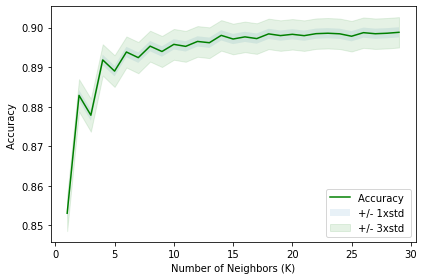

In [29]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [30]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8987941817919648 with k= 29


## Decision Tree Classification

In [31]:
#Decision Tree Classification
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

['Not severe' 'Not severe' 'Not severe' 'Not severe' 'Not severe']
['Not severe' 'Severe' 'Not severe' 'Not severe' 'Not severe']


In [32]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.8946486184459544


## Logistic Regression

In [33]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [34]:
yhat = LR.predict(X_test)

In [35]:
print (classification_report(y_test, yhat))
yhat_prob = LR.predict_proba(X_test)
print (jaccard_score(y_test, yhat,pos_label='Severe'))

              precision    recall  f1-score   support

  Not severe       0.91      0.98      0.94     48606
      Severe       0.67      0.29      0.40      6875

    accuracy                           0.89     55481
   macro avg       0.79      0.63      0.67     55481
weighted avg       0.88      0.89      0.88     55481

0.2532873739308056


# Results

## Trial 1

KNN
- The best accuracy was with 0.8757412447504551 with k= 23

Decision Tree
- DecisionTrees's Accuracy:  0.8716858023467493

## Trial 2

KNN
- The best accuracy was with 0.8987941817919648 with k= 29

Decision Tree
- DecisionTrees's Accuracy:  0.8946486184459544

Logistic Regression
- F1 score for "Not Severe" cases: 0.94
- F1 score for "Severe" cases: 0.40
- Accuracy: 0.89
- Jaccard score for "Severe" cases: 0.25